The best score I got was with Polynomial features creating interactions on ALL the continuous and binary vars. This made more than 50k columns. The score on Kaggle for the elastic net regression was .12074, which is the lowers I've gotten so far. However, this drastically increased training time for almost all the models. 

I think if I had more domain knowledge, I would only create the interactions that I think would matter. But for this exercise, creating all the possible interactions seems like a better "shotgun" approach. 

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import patsy
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np

pd.set_option('display.max_columns',100)
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, GridSearchCV
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.model_selection import cross_validate
df_raw = pd.read_csv('train.csv')
import xgboost

In [2]:
from sklearn.inspection import PartialDependenceDisplay

In [3]:
from sklearn.inspection import permutation_importance

In [4]:
import shap

In [56]:
from sklearn.preprocessing import OrdinalEncoder

Notes:
- Year Sold and Built not useful by itself, need to be changed into Age at Sale
- Year Sold minus Year Remodel gives time since last remodel
- MSSubClass will need some encoding (one-hot)
- MSZoning will need encoding
- Street can be one hot encoded
- Alley will be encoded
- LotShape encoded
- LandContour encoded
- Utilities encode

## Data Transforms

In [5]:
df = df_raw.copy()

In [6]:
df['AgeHouseAtSale'] = df['YrSold'] - df['YearBuilt']

df['YearsLastRemodelAtSale']  = df['YrSold'] - df['YearRemodAdd']

df['YearsGarageBuiltAtSale'] = df['YrSold'] - df['GarageYrBlt'] 

df.drop(columns=['Id'],inplace=True)

df['MSSubClass'] = df['MSSubClass'].astype(str)

In [7]:
df['YearsLastRemodelAtSale'] = np.maximum(df['YearsLastRemodelAtSale'],0)

In [8]:
df["SqFtPerRoom"]        = df["GrLivArea"] / \
                                                        (df["TotRmsAbvGrd"] + df["FullBath"]
                                                       + df["HalfBath"] + df["KitchenAbvGr"])
df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']
df['Total_Bathrooms']    = df['FullBath'] + 0.5 * df['HalfBath'] \
                                      + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df["HighQualSF"]         = df["1stFlrSF"] + df["2ndFlrSF"]



In [9]:
df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"] 
# df["GreenArea"] = df["LotArea"] - df["GrLivArea"] - df["GarageArea"]
for var in ['1stFlrSF','2ndFlrSF','TotalBsmtSF']:
    df[var+'Pct'] = df[var]/df['TotalSF']
# for var in ['GreenArea','GrLivArea','GarageArea']:
#     df[var+'Pct'] = df[var]/df['LotArea']

In [10]:
df.describe()

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1201.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     70.049958   10516.828082     6.099315     5.575342  1971.267808   
std      24.284752    9981.264932     1.382997     1.112799    30.202904   
min      21.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      59.000000    7553.500000     5.000000     5.000000  1954.000000   
50%      69.000000    9478.500000     6.000000     5.000000  1973.000000   
75%      80.000000   11601.500000     7.000000     6.000000  2000.000000   
max     313.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count   1460.000000  1452.000000  1460.000000  1460.000000  1460.000000   
mean    1984.865753   103.685262   443.639726    46.549315   567.240411   
std       20.645407   181.066207   456.098091   161.319273   441.866955   
min     1950.000000     0.000000     0.000000     0.000000     0.000000   
25%     1967.000000     0.000000     0.000000     0.000000   223.000000   
50%     1994.000000     0.000000   383.500000     0.000000   477.500000   
75%     2004.000000   166.000000   712.250000     0.000000   808.000000   
max     2010.000000  1600.000000  5644.000000  1474.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  1460.000000  1460.000000  1460.000000   1460.000000  1460.000000   
mean   1057.429452  1162.626712   346.992466      5.844521  1515.463699   
std     438.705324   386.587738   436.528436     48.623081   525.480383   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     795.750000   882.000000     0.000000      0.000000  1129.500000   
50%     991.500000  1087.000000     0.000000      0.000000  1464.000000   
75%    1298.250000  1391.250000   728.000000      0.000000  1776.750000   
max    6110.000000  4692.000000  2065.000000    572.000000  5642.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   1460.000000   1460.000000  1460.000000  1460.000000   1460.000000   
mean       0.425342      0.057534     1.565068     0.382877      2.866438   
std        0.518911      0.238753     0.550916     0.502885      0.815778   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     3.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  \
count   1460.000000   1460.000000  1460.000000  1379.000000  1460.000000   
mean       1.046575      6.517808     0.613014  1978.506164     1.767123   
std        0.220338      1.625393     0.644666    24.689725     0.747315   
min        0.000000      2.000000     0.000000  1900.000000     0.000000   
25%        1.000000      5.000000     0.000000  1961.000000     1.000000   
50%        1.000000      6.000000     1.000000  1980.000000     2.000000   
75%        1.000000      7.000000     1.000000  2002.000000     2.000000   
max        3.000000     14.000000     3.000000  2010.000000     4.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    472.980137    94.244521    46.660274      21.954110     3.409589   
std     213.804841   125.338794    66.256028      61.119149    29.317331   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     334.500000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    25.000000       0.000000     0.000000   
75%     576.000000   168.000000    68.000000       0.000000

In [11]:
for var in df.dtypes[df.dtypes == 'int64'].index:
    if df[var].isnull().sum()>0:
        df[var+'_isnull'] = df[var].isnull().astype(int)
        df[var]=df[var].fillna(df[var].mean())

for var in df.dtypes[df.dtypes == 'float64'].index:
    if df[var].isnull().sum()>0:
        df[var+'_isnull'] = df[var].isnull().astype(int)
        df[var]=df[var].fillna(df[var].mean())

df_dummies = pd.get_dummies(df,dummy_na=True,drop_first=False)

In [12]:
df_dummies.drop(columns=df_dummies.loc[:,df_dummies.nunique() == 1].columns, inplace=True)

In [13]:
X = df_dummies.drop(columns='SalePrice')

y = np.log(df_dummies['SalePrice'])

# X['intercept'] = 1

## Creating Interaction Terms

In [14]:
polynomial_features = PolynomialFeatures(degree=2,include_bias=True)
test_df = polynomial_features.fit_transform(X)
test_df = pd.DataFrame(polynomial_features.fit_transform(X), columns = polynomial_features.get_feature_names_out(X.columns))
from sklearn.base import BaseEstimator, TransformerMixin

class PolynomialFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, include_bias=True): # no *args or **kargs
        self.init = True
        self.degree = degree
        self.include_bias=include_bias
        self.polynomial_features = PolynomialFeatures(degree=degree,include_bias=include_bias)
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        test_df = self.polynomial_features.fit_transform(X)
        return  pd.DataFrame(self.polynomial_features.fit_transform(X), columns = self.polynomial_features.get_feature_names_out(X.columns))
polynomial_features = PolynomialFeaturesTransformer(degree=2,include_bias=True)
polynomial_features.fit(X)


PolynomialFeaturesTransformer()

## Creating own scaler

Based on taking the log first (adding a 1 so that 0s become 1s), and then centering and dividing out the standard deviation

The log standard is incredibly promising for Elastic Net. In fact, it's almost the best performing model yet (only beaten by the stacking regression)

Bayesian Ridge also showed improvement

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class LogStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.init = True
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        temp = np.log(X+1)
        X_scaled = (temp - temp.mean())/temp.std()
        return X_scaled.fillna(0)


In [16]:
test_scaler = LogStandardScaler()

In [17]:
class PandasGetDummies(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.init = True
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        return pd.get_dummies(X,dummy_na=True,drop_first=False)

# Training

## SKLEARN

### Lasso

In [18]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

### Elastic Net
With all of these interaction variables, fitting the CV for Elastic Net takes much longer (>6 minutes on my comp)
I think this has to do with having too many variables compared to observations, creating longer convergence times

In [38]:
from sklearn.linear_model import ElasticNetCV

In [39]:
# elastic_net_cv = ElasticNetCV(l1_ratio=[0,.5,1]
#                              ,alphas=[0.1,1,10,100]
#                              )
elastic_net_cv = ElasticNetCV(cv=5, random_state=0, l1_ratio=[0.5,0.7,0.8,0.9,1],max_iter=20000,n_jobs=-1)

In [40]:
elastic_net_pipeline = make_pipeline(
    # PolynomialFeaturesTransformer(),
LogStandardScaler(),elastic_net_cv)

In [41]:
elastic_net_pipeline.fit(X=X,y=y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('elasticnetcv',
                 ElasticNetCV(cv=5, l1_ratio=[0.5, 0.7, 0.8, 0.9, 1],
                              max_iter=20000, n_jobs=-1, random_state=0))])

In [42]:
elastic_net_cv.l1_ratio_

0.5

In [43]:
elastic_net_cv.alpha_

0.008518396506130982

In [44]:
pd.DataFrame(elastic_net_cv.coef_,index=X.columns).sort_values(by=0,ascending=False).head(20)

0
TotalSF               0.073597
Total_Home_Quality    0.064764
GrLivArea             0.058276
LotArea               0.037847
GarageCars            0.034212
YearBuilt             0.030163
Total_Bathrooms       0.022397
KitchenQual_Ex        0.019147
BsmtFinSF1            0.018988
Neighborhood_Crawfor  0.018377
BsmtQual_Ex           0.017798
Neighborhood_NoRidge  0.016199
Fireplaces            0.016011
Neighborhood_NridgHt  0.014730
Neighborhood_StoneBr  0.014375
YearRemodAdd          0.014077
Functional_Typ        0.013621
BsmtExposure_Gd       0.012742
HighQualSF            0.012557
Exterior1st_BrkFace   0.010272

In [46]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(l1_ratio=0.5,alpha=0.00794428509169608,max_iter=20000)
elastic_net_pipeline = make_pipeline(
    PolynomialFeaturesTransformer()
                                     ,LogStandardScaler()
                                     ,elastic_net)
elastic_net_pipeline.fit(X=X,y=y)

Pipeline(steps=[('polynomialfeaturestransformer',
                 PolynomialFeaturesTransformer()),
                ('logstandardscaler', LogStandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.00794428509169608, max_iter=20000))])

In [47]:
pd.DataFrame([elastic_net_pipeline['elasticnet'].feature_names_in_, elastic_net_pipeline['elasticnet'].coef_]).transpose().sort_values(by=1, ascending=False).head(20)

0         1
12583         Total_Home_Quality TotalSF  0.073091
4930        GrLivArea Total_Home_Quality  0.038104
1661              YearBuilt YearRemodAdd  0.032006
12582      Total_Home_Quality HighQualSF  0.031441
706              LotArea Total_Bathrooms  0.023776
13105     Total_Bathrooms Functional_Typ  0.017271
1698                   YearBuilt TotalSF  0.015069
6103             FullBath KitchenQual_Ex   0.01483
708                      LotArea TotalSF  0.013771
12286     SqFtPerRoom Total_Home_Quality  0.011596
8097              GarageCars Street_Pave  0.011437
8161            GarageCars BldgType_1Fam  0.009549
41799    Exterior1st_BrkFace BsmtQual_Gd  0.009423
1021              OverallQual GarageCars  0.008737
1369                 OverallCond TotalSF  0.008139
680                    LotArea GrLivArea  0.007685
48702       BsmtQual_Ex BsmtFinType1_GLQ  0.007534
7211   TotRmsAbvGrd Neighborhood_StoneBr   0.00728
2520         MasVnrArea Foundation_PConc  0.006812
2420     MasVnrArea Neighborhood_NridgHt  0.006597

## XGBoost

In [19]:
xg_boost = xgboost.XGBRegressor(n_estimators=800,learning_rate=0.05)
xg_boost_pipeline = make_pipeline(
    # LogStandardScaler(),

xg_boost)

In [49]:
params_xg = {
    # 'xgbregressor__n_estimators':[400,600,800],
# 'xgbregressor__learning_rate':[0.01,0.05,0.1]
    'xgbregressor__max_depth':[2, 3, 5],
    # 'xgbregressor__gamma':[0],
    'xgbregressor__min_child_weight':[1, 2, 3, 4],
    # 'xgbregressor__subsample':[0.5, 0.7, 0.8, 0.9, 1],
    'xgbregressor__colsample_bytree':[0.3 ,0.5, 0.7],
}

In [21]:
xg_boost = xgboost.XGBRegressor(n_estimators=800,learning_rate=0.05, colsample_bytree = 0.7, max_depth = 3, min_child_weight=4)
xg_boost_pipeline = make_pipeline(
    # LogStandardScaler(),
xg_boost)
xg_boost_pipeline.fit(X,y)

Pipeline(steps=[('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.05, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=3, max_leaves=0, min_child_weight=4,
                              missing=nan, monotone_constraints='()',
                              n_estimators=800, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [22]:
pd.DataFrame([xg_boost_pipeline['xgbregressor'].feature_names_in_, xg_boost_pipeline['xgbregressor'].feature_importances_]).transpose().sort_values(by=1, ascending=False).head(20)

0         1
277         FireplaceQu_nan  0.095388
22               Fireplaces  0.076262
42                  TotalSF  0.068745
24               GarageCars    0.0558
213             BsmtQual_Ex  0.047564
40          Total_Bathrooms  0.044066
2               OverallQual  0.041427
35           AgeHouseAtSale  0.037873
69              MSZoning_RM  0.030189
39       Total_Home_Quality  0.029773
253            CentralAir_N  0.027335
293           GarageQual_TA  0.019739
68              MSZoning_RL  0.018006
36   YearsLastRemodelAtSale  0.017471
299           GarageCond_TA  0.012084
14                GrLivArea  0.011083
55            MSSubClass_30  0.008331
288        GarageFinish_nan  0.008237
65         MSZoning_C (all)  0.007921
20             KitchenAbvGr  0.007278

### Xgboost PDP

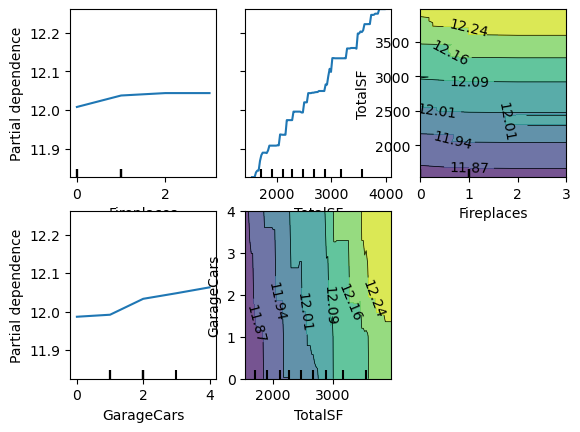

In [31]:
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(xg_boost, X, 
     # features,
     features= ['Fireplaces','TotalSF',['Fireplaces','TotalSF'], 'GarageCars',['TotalSF','GarageCars']]
     # kind='individual'
     )

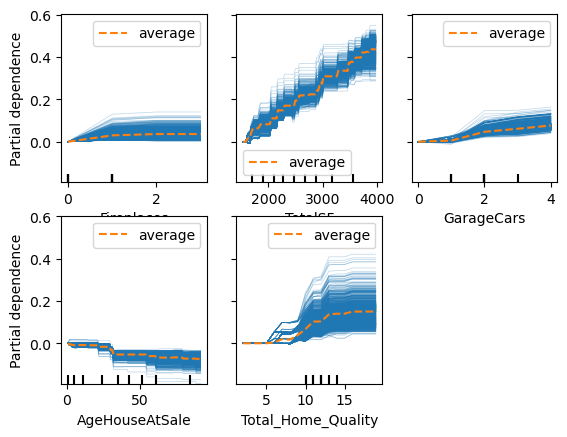

In [36]:
### ICE
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(xg_boost, X, 
     # features,
     features= ['Fireplaces','TotalSF', 'GarageCars','AgeHouseAtSale','Total_Home_Quality'],
     kind='both',
     centered=True
     )

### Permutation Importance
It takes a while to run, and has issues with correlated variables. But it still gives pretty good indications of which variables are the most predictive and important. It actually seems like for XGBoost, OrdinalEncoder and GetDummies does the same thing, which makes sense. But OrdinalEncoder trains a lot faster for a tree, since there's way less columns. Actually, OrdinalEncoder might be more interpretable too, since it'll give the impact of the whole Categorical Column

In [1]:
from sklearn.preprocessing import OrdinalEncoder

In [70]:
# xg_boost_pimp = xgboost.XGBRegressor(n_estimators=800,learning_rate=0.05)
xg_boost_pimp = xgboost.XGBRegressor(n_estimators=800,learning_rate=0.05, colsample_bytree = 0.7, max_depth = 3, min_child_weight=4)
xg_boost_pipelin_pimp = make_pipeline(
    # LogStandardScaler(),
    # PandasGetDummies(),
    OrdinalEncoder(),
xg_boost_pimp)

In [71]:
xg_boost_pipelin_pimp.fit(df.drop(columns=['SalePrice']), df['SalePrice'])

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.05, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=3, max_leaves=0, min_child_weight=4,
                              missing=nan, monotone_constraints='()',
                              n_estimators=800, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [72]:
pd.DataFrame(xg_boost_pipelin_pimp['ordinalencoder'].feature_names_in_, xg_boost_pipelin_pimp['xgbregressor'].feature_importances_).sort_index(ascending=False).head(20)

0
0.181555         OverallQual
0.151353             TotalSF
0.131316            BsmtQual
0.127990          GarageCars
0.040827          CentralAir
0.040098     Total_Bathrooms
0.024460  Total_Home_Quality
0.020228         KitchenQual
0.018770          Fireplaces
0.018648            2ndFlrSF
0.017168          GarageType
0.016750        GarageFinish
0.012417          HighQualSF
0.011389      AgeHouseAtSale
0.011184        KitchenAbvGr
0.011181        YearRemodAdd
0.009481           YearBuilt
0.009299           GrLivArea
0.008481          BsmtFinSF1
0.008293            BldgType

In [73]:
## Permutation Importance
r = permutation_importance(xg_boost_pipelin_pimp, df.drop(columns=['SalePrice']), df['SalePrice'],
                           n_repeats=30,
                           random_state=0)

In [74]:
## I think permutation importance doesn't work as well with categorical, unless we include the one-hot encode in the pipeline
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

HighQualSF 0.229 +/- 0.008
OverallQual 0.084 +/- 0.003
SqFtPerRoom 0.013 +/- 0.001
LotArea  0.013 +/- 0.001
Total_Home_Quality 0.012 +/- 0.000
BsmtFinSF1 0.009 +/- 0.001
Neighborhood 0.009 +/- 0.001
GarageCars 0.008 +/- 0.000
SalePrice 0.008 +/- 0.000
2ndFlrSF 0.007 +/- 0.000
BsmtUnfSF 0.005 +/- 0.000
BsmtQual 0.005 +/- 0.000
YearBuilt 0.005 +/- 0.000
OverallCond 0.005 +/- 0.000
GarageArea 0.004 +/- 0.000
GrLivArea 0.003 +/- 0.000
YearRemodAdd 0.003 +/- 0.000
KitchenQual 0.003 +/- 0.000
LotFrontage 0.003 +/- 0.000
SaleCondition 0.002 +/- 0.000
TotalBsmtSF 0.002 +/- 0.000
Condition1 0.002 +/- 0.000
WoodDeckSF 0.002 +/- 0.000
YearsGarageBuiltAtSale 0.002 +/- 0.000
GarageYrBlt 0.002 +/- 0.000
Fireplaces 0.002 +/- 0.000
OpenPorchSF 0.002 +/- 0.000
MSZoning 0.002 +/- 0.000
Total_Bathrooms 0.002 +/- 0.000
Functional 0.002 +/- 0.000
1stFlrSF 0.002 +/- 0.000
BedroomAbvGr 0.001 +/- 0.000
MasVnrArea 0.001 +/- 0.000
ScreenPorch 0.001 +/- 0.000
AgeHouseAtSale 0.001 +/- 0.000
Exterior1st 0.001 +/- 

### ALE

In [42]:
from PyALE import ale

PyALE._ALE_generic:INFO: Continuous feature detected.


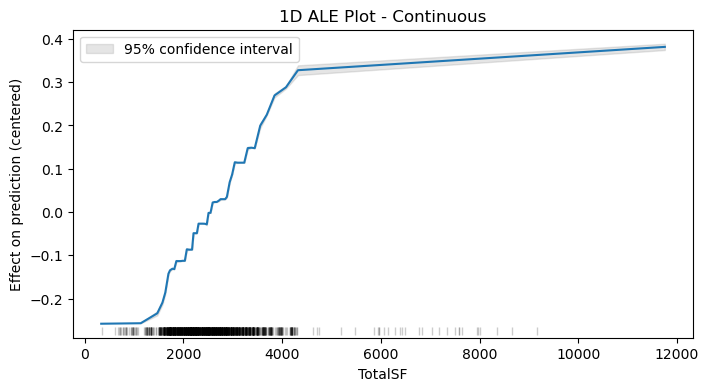

In [44]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X, model=xg_boost, feature=["TotalSF"], grid_size=50, include_CI=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


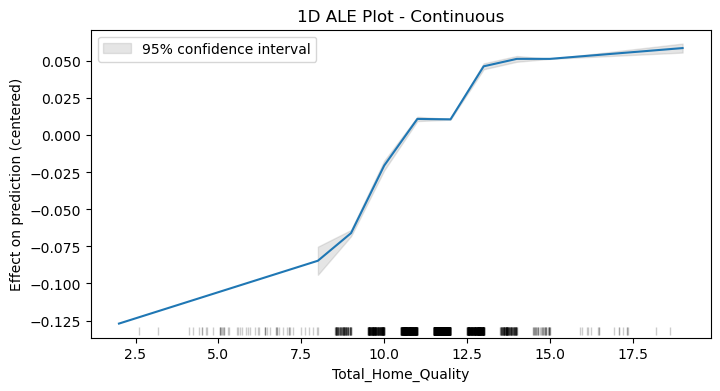

In [47]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X, model=xg_boost, feature=["Total_Home_Quality"], grid_size=50, include_CI=True
)

### Surrogate Model

In [65]:
y_pred_xgboost = xg_boost.predict(X)

In [66]:
lasso_cv = LassoCV(cv=5, random_state=0,max_iter=20000)
lasso_pipeline = make_pipeline(LogStandardScaler()
                               ,lasso_cv)
lasso_pipeline.fit(X=X,y=y_pred_xgboost)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('lassocv', LassoCV(cv=5, max_iter=20000, random_state=0))])

In [67]:
val_results = cross_validate(lasso_pipeline,X,y_pred_xgboost, scoring=['neg_mean_squared_error','r2'], n_jobs=-1)
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean      std       min       25%       50%       75%       max
0    5.0 -0.009241  0.00333 -0.013752 -0.011468 -0.008055 -0.007516 -0.005412

In [69]:
pd.DataFrame(val_results['test_r2']).describe().transpose()

count      mean       std       min       25%      50%       75%       max
0    5.0  0.939536  0.021328  0.906736  0.932814  0.94564  0.949073  0.963418

In [71]:
lasso_xgboost = pd.DataFrame([lasso_cv.feature_names_in_,lasso_cv.coef_]).transpose()

In [72]:
lasso_xgboost.columns = ['feature','coef']

In [73]:
lasso_xgboost.sort_values(by='coef',ascending=False).head(20)

feature      coef
42                TotalSF  0.072994
14              GrLivArea  0.067436
39     Total_Home_Quality  0.061986
1                 LotArea  0.037609
24             GarageCars  0.033056
4               YearBuilt  0.032191
40        Total_Bathrooms  0.021385
7              BsmtFinSF1  0.018609
99   Neighborhood_Crawfor  0.018025
261        KitchenQual_Ex  0.017985
213           BsmtQual_Ex  0.017878
2             OverallQual  0.016977
5            YearRemodAdd  0.016515
22             Fireplaces  0.016342
108  Neighborhood_NoRidge  0.015491
109  Neighborhood_NridgHt  0.013592
271        Functional_Typ  0.013438
115  Neighborhood_StoneBr  0.013162
11               1stFlrSF  0.012704
224       BsmtExposure_Gd  0.011611

In [75]:
lasso_xgboost.sort_values(by='coef',ascending=True).head(10)

feature      coef
154        RoofMatl_ClyTile -0.036352
65         MSZoning_C (all) -0.024983
131         Condition2_PosN   -0.0184
327   SaleCondition_Abnorml -0.013612
69              MSZoning_RM -0.013609
20             KitchenAbvGr -0.010604
201            ExterQual_TA -0.010493
100    Neighborhood_Edwards   -0.0086
37   YearsGarageBuiltAtSale -0.007894
35           AgeHouseAtSale -0.007595

### SHAP

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.


  0%|          | 0/1460 [00:00<?, ?it/s]

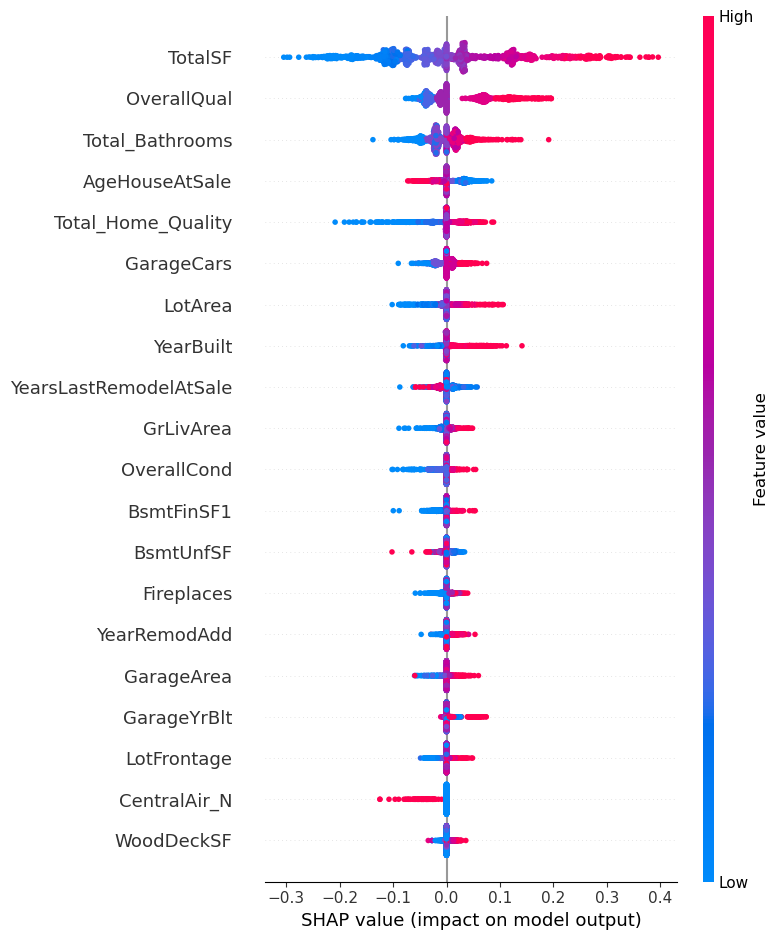

In [23]:
 
np.random.seed(111)
X_train_summary = shap.kmeans(X, 10)
shap_svm_explainer = shap.KernelExplainer(xg_boost.predict, X_train_summary)
shap_svm_values_test = shap_svm_explainer.shap_values(X,nsamples=200, l1_reg="num_features(20)")
shap.summary_plot(shap_svm_values_test, X, plot_type="dot")

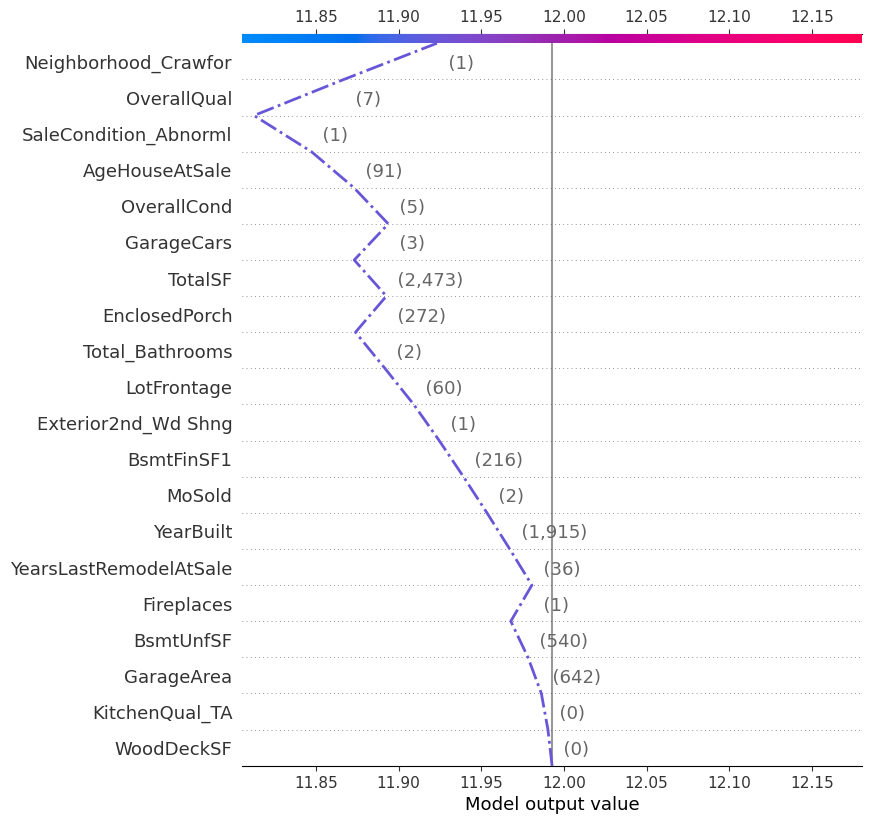

In [137]:
shap.decision_plot(shap_svm_explainer.expected_value, shap_svm_values_test[[3]], X.iloc[[3]], highlight=0)

In [98]:
shap.initjs()
shap.force_plot(shap_svm_explainer.expected_value,
shap_svm_values_test[[696]],\
X.iloc[[696]], matplotlib=False)

In [24]:
explainer = shap.Explainer(xg_boost)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


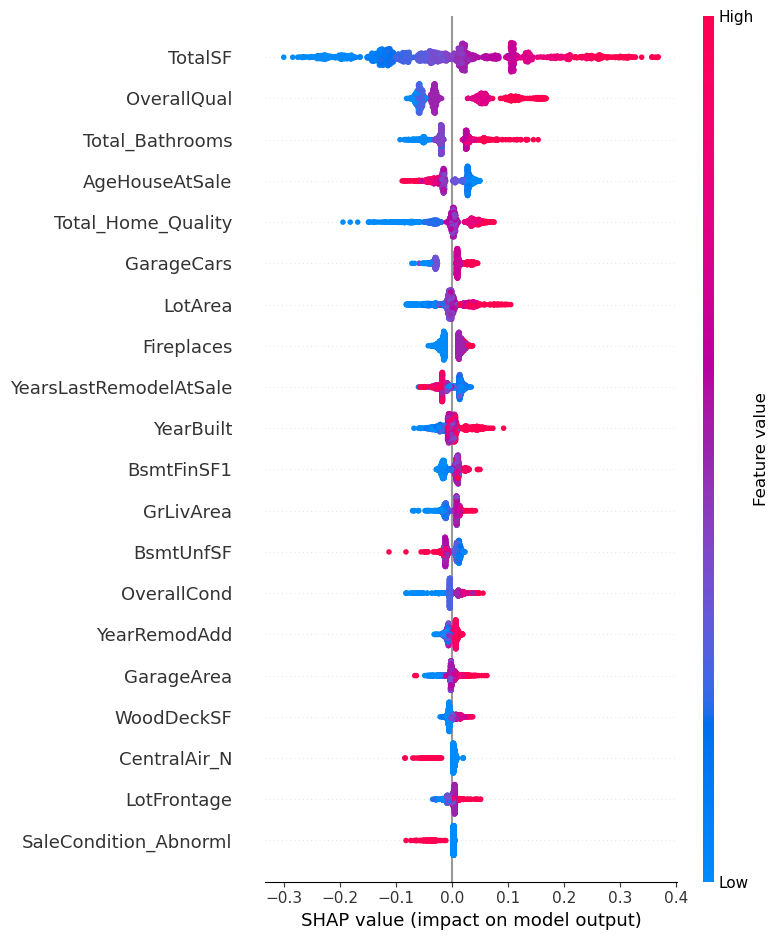

In [25]:
shap.summary_plot(shap_values, X, plot_type="dot")

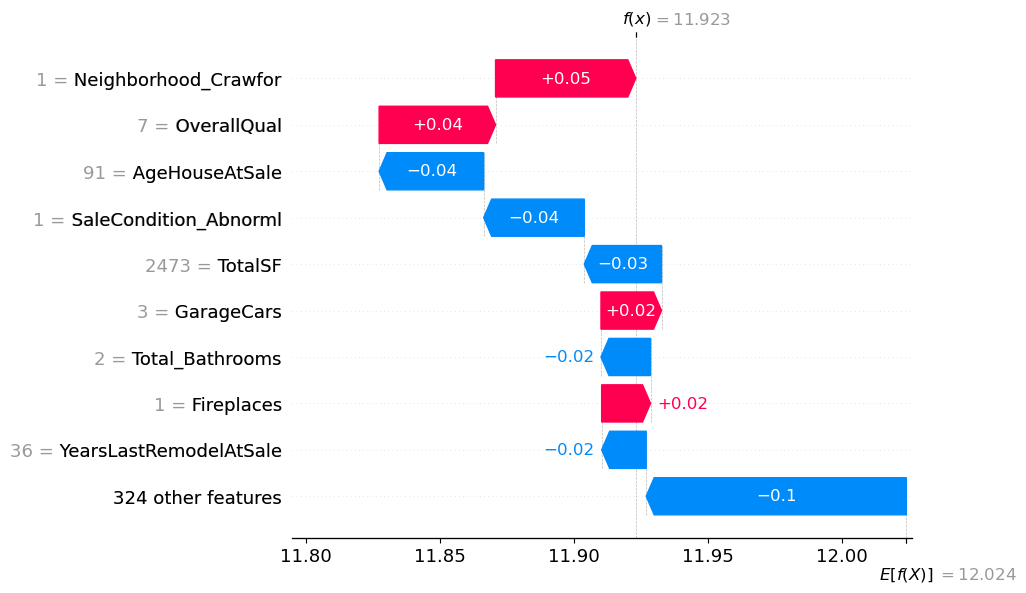

In [26]:
shap.plots.waterfall(shap_values[3])

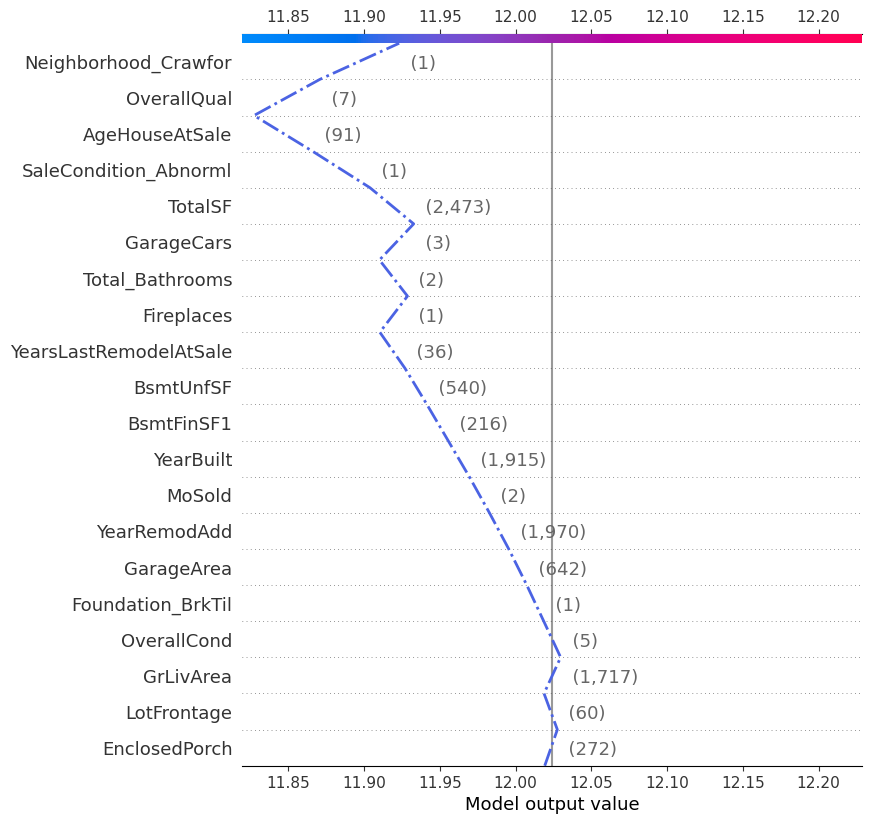

In [142]:
shap.decision_plot(explainer.expected_value, shap_values.values[[3]], X.iloc[[3]], highlight=0)

### LIME

In [89]:
import lime
import lime.lime_tabular

In [128]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns.values, 
class_names=['SalePrice'], 
discretize_continuous=True,
categorical_features= X.loc[:,X.nunique() == 2].columns,
mode='regression')

In [131]:
i = np.random.randint(0, X.shape[0])
exp = explainer.explain_instance(X.values[i], xg_boost.predict, num_features=8, top_labels=1)

In [132]:
exp.show_in_notebook(show_table=True)

## Random Forest


In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
random_forest = RandomForestRegressor(max_depth=None, max_features=0.4, 
                      n_estimators=600)

In [20]:
random_forest.fit(X,y)

RandomForestRegressor(max_features=0.4, n_estimators=600)

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


  0%|          | 0/1460 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

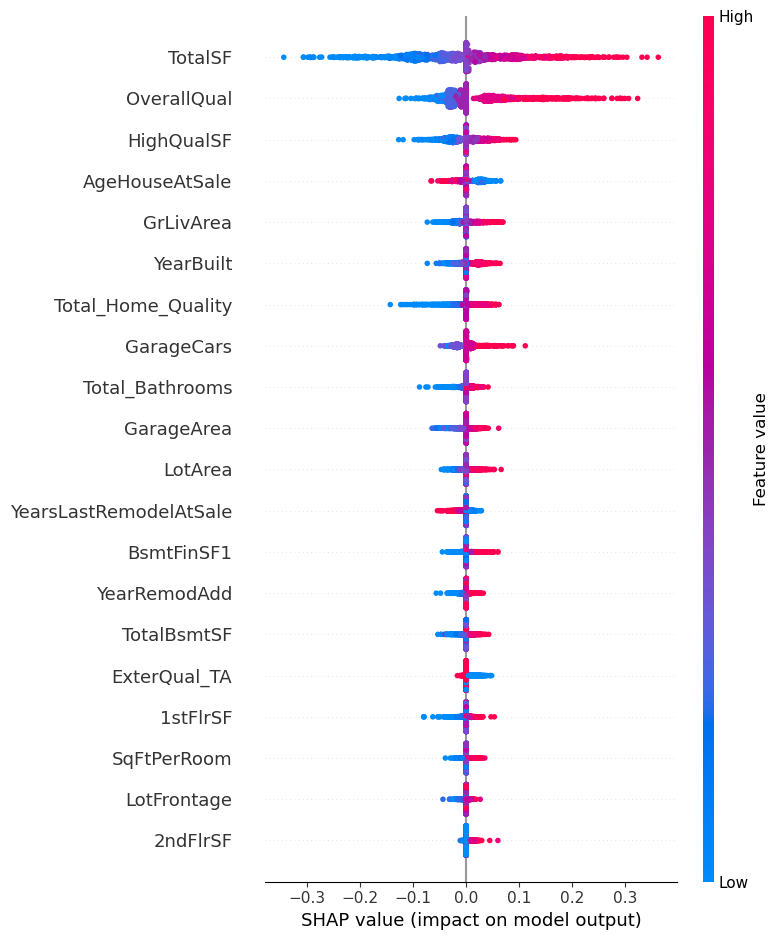

In [26]:
np.random.seed(111)
X_train_summary = shap.kmeans(X, 10)
shap_svm_explainer_rf = shap.KernelExplainer(random_forest.predict, X_train_summary)
shap_svm_values_test_rf = shap_svm_explainer_rf.shap_values(X,nsamples=200, l1_reg="num_features(20)")
shap.summary_plot(shap_svm_values_test_rf, X, plot_type="dot")

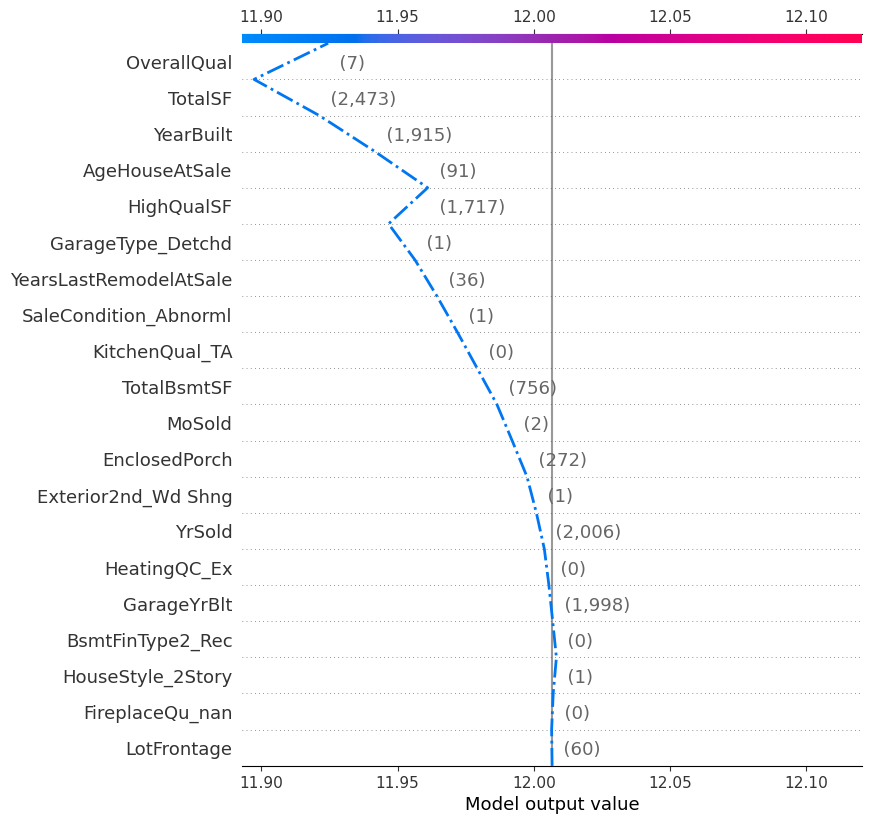

In [29]:
shap.decision_plot(shap_svm_explainer_rf.expected_value, shap_svm_values_test_rf[[3]], X.iloc[[3]], highlight=0)

In [45]:
shap.force_plot(shap_svm_explainer_rf.expected_value, shap_svm_values_test_rf[3], X.iloc[3], link="logit")

## Light GBM
Light GBM breaks because of the Patsy naming convention (creating interactions with : in the middle)

In [46]:
from lightgbm import LGBMRegressor

In [66]:
light_gbm = LGBMRegressor(n_estimators=800,learning_rate=0.05 ,max_depth=3, num_leaves=5, min_child_weight=0.00001, subsample=0.3, colsample_bytree = 0.3, lambda_l1 = 0.1)

light_gbm_pipeline = make_pipeline(
    # LogStandardScaler(),
    # OrdinalEncoder(),
light_gbm)

light_gbm_pipeline.fit(X,y)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


Pipeline(steps=[('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.3, lambda_l1=0.1,
                               learning_rate=0.05, max_depth=3,
                               min_child_weight=1e-05, n_estimators=800,
                               num_leaves=5, subsample=0.3))])

In [58]:
light_gbm_pimp = make_pipeline(
    # LogStandardScaler(),
    OrdinalEncoder(),
light_gbm)
light_gbm_pimp.fit(df.drop(columns=['SalePrice']), df['SalePrice'])

r_light = permutation_importance(light_gbm_pimp, df.drop(columns=['SalePrice']), df['SalePrice'],
                           n_repeats=30,
                           random_state=0)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


In [60]:
## I think permutation importance doesn't work as well with categorical, unless we include the one-hot encode in the pipeline
for i in r_light.importances_mean.argsort()[::-1]:
    if r_light.importances_mean[i] - 2 * r_light.importances_std[i] > 0:
        print(f"{df.drop(columns=['SalePrice']).columns[i]:<8} "
              f"{r_light.importances_mean[i]:.3f}"
              f" +/- {r_light.importances_std[i]:.3f}")

TotalSF  0.103 +/- 0.004
OverallQual 0.028 +/- 0.001
Total_Home_Quality 0.025 +/- 0.001
HighQualSF 0.018 +/- 0.001
AgeHouseAtSale 0.016 +/- 0.001
LotArea  0.013 +/- 0.001
Total_Bathrooms 0.012 +/- 0.001
Neighborhood 0.011 +/- 0.001
OpenPorchSF 0.008 +/- 0.001
BsmtFinSF1 0.008 +/- 0.001
1stFlrSF 0.008 +/- 0.001
GarageCars 0.007 +/- 0.001
GarageArea 0.006 +/- 0.000
TotalBsmtSF 0.005 +/- 0.000
ExterQual 0.004 +/- 0.001
BsmtUnfSF 0.004 +/- 0.000
YearBuilt 0.004 +/- 0.000
LotFrontage 0.004 +/- 0.000
BsmtQual 0.003 +/- 0.000
GrLivArea 0.003 +/- 0.000
KitchenQual 0.003 +/- 0.000
SqFtPerRoom 0.003 +/- 0.000
OverallCond 0.003 +/- 0.000
2ndFlrSF 0.003 +/- 0.000
MasVnrArea 0.002 +/- 0.000
SaleCondition 0.002 +/- 0.000
Condition1 0.002 +/- 0.000
BsmtExposure 0.002 +/- 0.000
Fireplaces 0.002 +/- 0.000
YearRemodAdd 0.002 +/- 0.000
LandContour 0.002 +/- 0.000
WoodDeckSF 0.002 +/- 0.000
MoSold   0.002 +/- 0.000
ScreenPorch 0.002 +/- 0.000
GarageYrBlt 0.002 +/- 0.000
Exterior1st 0.002 +/- 0.000
2ndFlrS

In [67]:
explainer_light = shap.TreeExplainer(light_gbm_pipeline['lgbmregressor'])
shap_values_light = explainer_light(X)

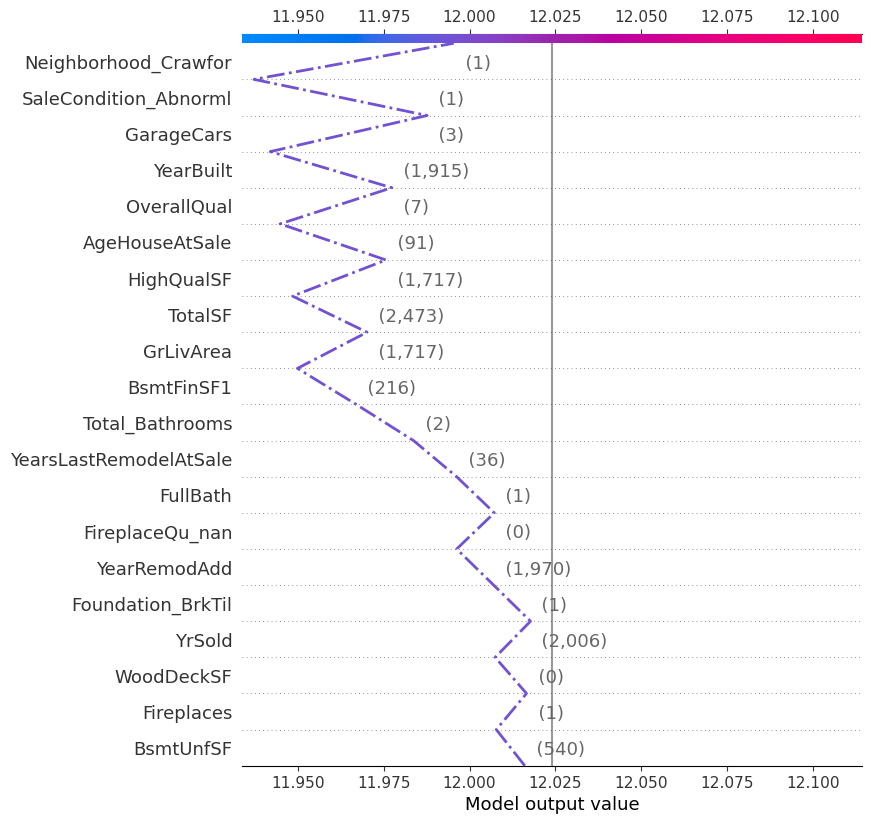

In [75]:
shap.decision_plot(explainer_light.expected_value,shap_values_light.values[3], X.iloc[[3]], highlight=0)

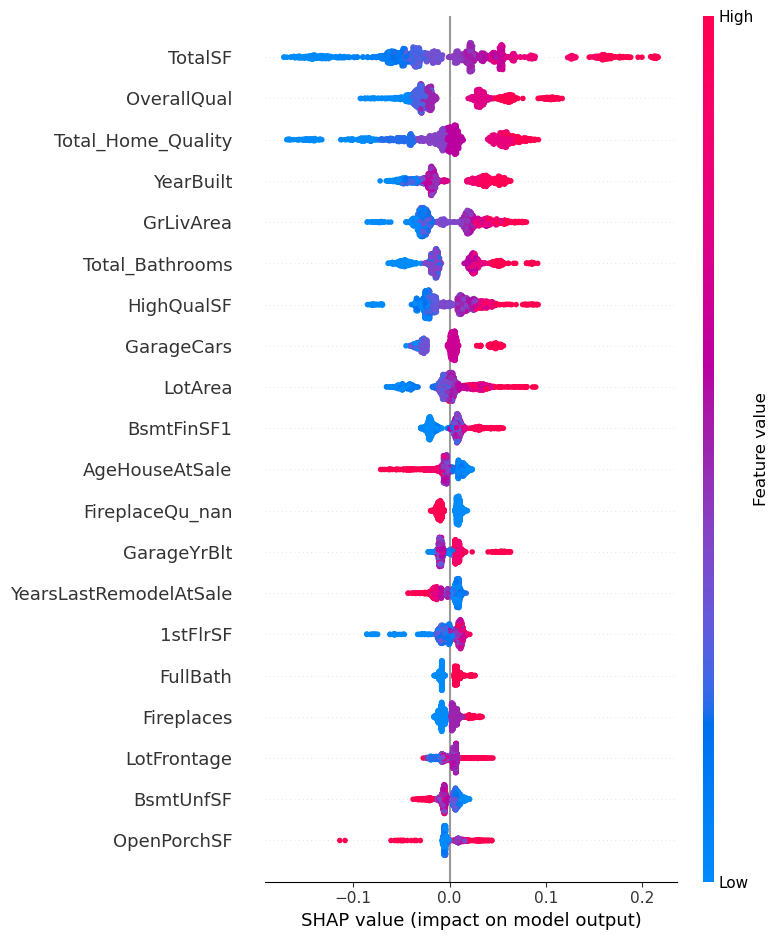

In [78]:
shap.summary_plot(shap_values_light.values,X)

## from sklearn.linear_model import BayesianRidge

In [164]:
from sklearn.linear_model import BayesianRidge

In [171]:
bayesianr = BayesianRidge()

bayesianr_pipeline = make_pipeline(
    # PolynomialFeaturesTransformer(),
    LogStandardScaler(),
    bayesianr)

bayesianr_pipeline.fit(X,y)

Pipeline(steps=[('logstandardscaler', LogStandardScaler()),
                ('bayesianridge', BayesianRidge())])

In [177]:
bayesianr_pipeline['bayesianridge'].

SyntaxError: invalid syntax (17819437.py, line 1)

In [178]:
bayesianr.alpha_

96.69951275089076

In [179]:
bayesianr.coef_

array([ 7.45914156e-03,  3.77056559e-02,  4.06458071e-02,  3.61110875e-02,
        2.30057834e-02,  1.86658576e-02,  5.49125432e-03,  1.94884647e-02,
       -1.21363738e-03, -1.00124104e-02,  1.19653052e-02,  3.90666688e-02,
        3.06096554e-03, -2.23287602e-04,  4.87727344e-02,  1.29637398e-02,
        1.37571865e-03,  1.58681078e-02,  1.35063409e-02, -2.33553989e-03,
       -9.45272336e-03,  1.12833791e-02,  1.35021158e-02,  1.36015689e-03,
        2.76778728e-02,  1.29687363e-02,  9.11980620e-03,  4.19442535e-03,
        2.90634776e-03,  2.16097195e-03,  1.11441898e-02,  5.14792286e-03,
       -3.84483158e-03, -7.49958532e-04, -3.40519743e-03, -9.63667953e-03,
        2.02211566e-03, -3.31888884e-03,  5.01327087e-02, -1.46343493e-02,
        9.39183552e-03, -5.84109579e-04,  4.44644181e-03, -1.54130682e-03,
        1.50018742e-03,  1.50018742e-03,  1.16363757e-04, -7.33423031e-03,
        3.21245639e-03,  7.20281577e-07,  5.75158288e-03, -6.15518283e-03,
       -9.10986724e-04, -

## Catboost

In [79]:
from catboost import CatBoostRegressor

In [80]:
catboost_reg = CatBoostRegressor(n_estimators=400,learning_rate=0.1,logging_level='Silent', subsample= 0.7)

In [82]:
catboost_reg.fit(X,y)

In [83]:
explainer_cat = shap.TreeExplainer(catboost_reg)
shap_values_cat = explainer_cat(X)

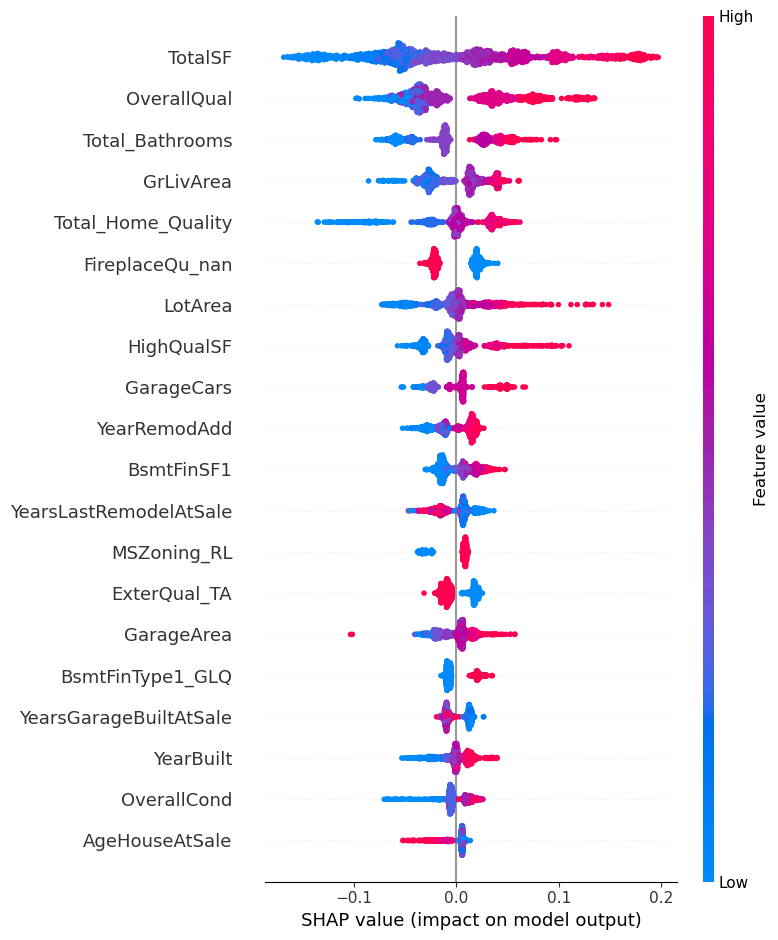

In [84]:
shap.summary_plot(shap_values_cat,X)

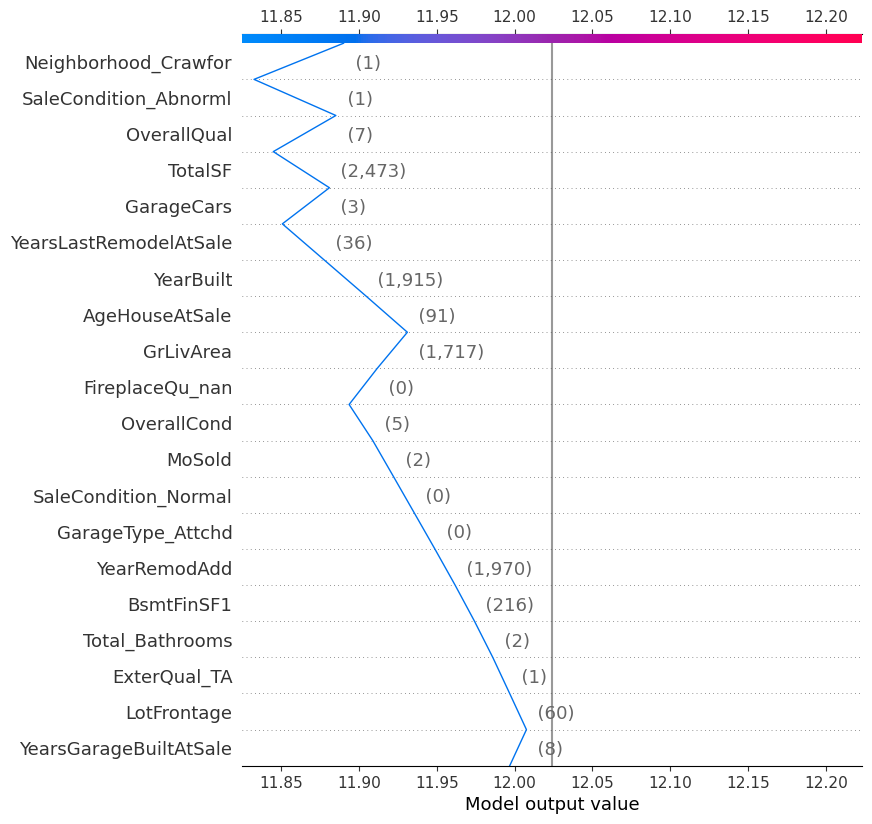

In [88]:
shap.decision_plot(explainer_cat.expected_value,shap_values_cat.values[3],X.iloc[3])

In [90]:
explainer_light_lime = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns.values, 
                                                class_names=['SalePrice'], 
                                                discretize_continuous=True,
                                                categorical_features= X.loc[:,X.nunique() == 2].columns,
                                                mode='regression')

In [93]:
exp_lime = explainer_light_lime.explain_instance(X.iloc[3],catboost_reg.predict, num_features=8)

In [94]:
exp_lime.show_in_notebook()

## Ensemble

In [33]:
from sklearn.ensemble import VotingRegressor, StackingRegressor

In [143]:
voting_reg = VotingRegressor([('elastic_net',elastic_net_pipeline)
                            #   ,('rf',random_forest_pipeline)
                              ,('xg_boost',xg_boost_pipeline)
                             # ,('adaboost',adaboost_pipeline)
                                  ,('lightgbm',light_gbm_pipeline)
                                  ,('gbr',gbr_pipeline)
                                #   ,('bayesianRidge',bayesianr_pipeline)
                                  # ,('kernelRidge',kernelr)
                             ])

In [144]:
voting_reg.fit(X,y)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


VotingRegressor(estimators=[('elastic_net',
                             Pipeline(steps=[('polynomialfeaturestransformer',
                                              PolynomialFeaturesTransformer()),
                                             ('logstandardscaler',
                                              LogStandardScaler()),
                                             ('elasticnet',
                                              ElasticNet(alpha=0.00794428509169608,
                                                         max_iter=20000))])),
                            ('xg_boost',
                             Pipeline(steps=[('logstandardscaler',
                                              LogStandardScaler()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=0....
                                              LGBMRegressor(colsample_bytree=0.3,
                                                            lambda_l1=0.1,
                                                            learning_rate=0.05,
                                                            max_depth=3,
                                                            min_child_weight=1e-05,
                                                            n_estimators=800,
                                                            num_leaves=5,
                                                            subsample=0.3))])),
                            ('gbr',
                             Pipeline(steps=[('logstandardscaler',
                                              LogStandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(learning_rate=0.05,
                                                                        max_features=0.4,
                                                                        max_leaf_nodes=30,
                                                                        n_estimators=800,
                                                                        subsample=0.8))]))])

In [227]:
stacking_reg = StackingRegressor([('elastic_net',elastic_net_pipeline)
                              # ,('rf',random_forest_pipeline)
                              ,('xg_boost',xg_boost_pipeline)
                             # ,('adaboost',adaboost_pipeline)
                                  ,('lightgbm',light_gbm_pipeline)
                                  ,('gbr',gbr_pipeline)
                              #     ,('bayesianRidge',bayesianr_pipeline)
                                  # ,('kernelRidge',kernelr)
                                  ,('catboost',catboost_reg)
                             ]
                            #  , final_estimator=ElasticNet(alpha=0.1)
                             ,cv= 3
                             ,final_estimator=catboost_reg
                             , passthrough=True)

In [228]:
stacking_reg.fit(X,y)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


StackingRegressor(cv=3,
                  estimators=[('elastic_net',
                               Pipeline(steps=[('polynomialfeaturestransformer',
                                                PolynomialFeaturesTransformer()),
                                               ('logstandardscaler',
                                                LogStandardScaler()),
                                               ('elasticnet',
                                                ElasticNet(alpha=0.00794428509169608,
                                                           max_iter=20000))])),
                              ('xg_boost',
                               Pipeline(steps=[('xgbregressor',
                                                XGBRegressor(base_score=0.5,
                                                             booster='gbtree',
                                                             callbacks=None,
                                                             c...
                                                              subsample=0.3))])),
                              ('gbr',
                               Pipeline(steps=[('gradientboostingregressor',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          max_features=0.4,
                                                                          max_leaf_nodes=30,
                                                                          n_estimators=800,
                                                                          subsample=0.8))])),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x000001B72E347400>)],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x000001B72E347400>,
                  passthrough=True)

## Cross Val Score

In [97]:
val_results = cross_validate(lasso_pipeline,X,y, scoring=['neg_mean_squared_error','r2'], n_jobs=-1)
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean       std       min       25%       50%       75%      max
0    5.0 -0.015797  0.003957 -0.020459 -0.018566 -0.015864 -0.013645 -0.01045

In [193]:
val_results = cross_validate(elastic_net_pipeline,X,y, scoring=['neg_mean_squared_error','r2'],n_jobs=-1)
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean       std       min       25%       50%       75%       max
0    5.0 -0.016234  0.003941 -0.021535 -0.018135 -0.016469 -0.013681 -0.011352

In [195]:
val_results = cross_validate(xg_boost_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean       std      min       25%       50%       75%       max
0    5.0 -0.014892  0.002631 -0.01758 -0.016339 -0.016314 -0.012788 -0.011438

In [52]:
val_results = cross_validate(random_forest,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean       std       min       25%       50%      75%       max
0    5.0 -0.018843  0.002904 -0.022583 -0.020186 -0.019576 -0.01642 -0.015448

In [161]:
val_results = cross_validate(light_gbm_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


count      mean       std       min       25%       50%       75%       max
0    5.0 -0.015409  0.002265 -0.017502 -0.017197 -0.016411 -0.012971 -0.012962

In [163]:
val_results = cross_validate(gbr_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean       std       min       25%       50%       75%       max
0    5.0 -0.014691  0.003531 -0.019231 -0.017045 -0.014612 -0.011772 -0.010795

In [168]:
val_results = cross_validate(bayesianr_pipeline,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean       std       min       25%       50%       75%       max
0    5.0 -0.020058  0.008451 -0.034016 -0.021742 -0.016922 -0.013957 -0.013655

In [226]:
val_results = cross_validate(catboost_reg,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean       std       min     25%       50%       75%       max
0    5.0 -0.014059  0.002386 -0.016331 -0.0161 -0.014812 -0.011662 -0.011388

In [272]:
val_results = cross_validate(voting_reg,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

count      mean       std       min       25%       50%       75%       max
0    5.0 -0.014984  0.002678 -0.018672 -0.016118 -0.015262 -0.013029 -0.011838

In [229]:
val_results = cross_validate(stacking_reg,X,y, scoring=['neg_mean_squared_error','r2'])
pd.DataFrame(val_results['test_neg_mean_squared_error']).describe().transpose()

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored.

count      mean       std       min       25%       50%       75%      max
0    5.0 -0.014305  0.002647 -0.017767 -0.015783 -0.014614 -0.011683 -0.01168

Scaling seems to have really benefitted the linear regression Elastic Net, but did not affect the tree based formulas much. 

Somehow kernalr is much worse now. 

# Prediction

In [39]:
df_predict_raw = pd.read_csv('test.csv')

In [40]:
df_predict = df_predict_raw.copy()

In [41]:
df_predict['AgeHouseAtSale'] = df_predict['YrSold'] - df_predict['YearBuilt']

df_predict['YearsLastRemodelAtSale']  = df_predict['YrSold'] - df_predict['YearRemodAdd']

df_predict['YearsGarageBuiltAtSale'] = df_predict['YrSold'] - df_predict['GarageYrBlt'] 

df_predict.drop(columns=['Id'],inplace=True)

df_predict['MSSubClass'] = df_predict['MSSubClass'].astype(str)

In [42]:
df_predict["TotalSF"] = df_predict["1stFlrSF"] + df_predict["2ndFlrSF"] + df_predict["TotalBsmtSF"] 
# df_predict["GreenArea"] = df_predict["LotArea"] - df_predict["GrLivArea"] - df_predict["GarageArea"]
for var in ['1stFlrSF','2ndFlrSF','TotalBsmtSF']:
    df_predict[var+'Pct'] = df_predict[var]/df_predict['TotalSF']
# for var in ['LotArea','GrLivArea','GarageArea']:
#     df_predict[var+'Pct'] = df_predict[var]/df_predict['GreenArea']

In [43]:
df_predict['YearsLastRemodelAtSale'] = np.maximum(df_predict['YearsLastRemodelAtSale'],0)
df_predict['AgeHouseAtSale'] = np.maximum(df_predict['AgeHouseAtSale'],0)
df_predict['YearsGarageBuiltAtSale'] = np.maximum(df_predict['YearsGarageBuiltAtSale'],0)

In [44]:
for var in df_predict.dtypes[df_predict.dtypes == 'int64'].index:
    if df_predict[var].isnull().sum()>0:
        df_predict[var+'_isnull'] = df_predict[var].isnull().astype(int)
        df_predict[var]=df_predict[var].fillna(df_predict[var].mean())

for var in df_predict.dtypes[df_predict.dtypes == 'float64'].index:
    if df_predict[var].isnull().sum()>0:
        df_predict[var+'_isnull'] = df_predict[var].isnull().astype(int)
        df_predict[var]=df_predict[var].fillna(df_predict[var].mean())

df_predict_dummies = pd.get_dummies(df_predict,dummy_na=True,drop_first=False)

In [45]:
_, df_predict_dummies = X.align(df_predict_dummies, axis=1, fill_value=0)

In [46]:
df_predict_dummies.drop(columns=df_predict_dummies.columns[~df_predict_dummies.columns.isin(X.columns)],inplace=True)

## Predictions

### Lasso

In [124]:
df_predict_raw['SalePrice'] = np.exp(lasso_pipeline.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_lasso_p7.csv',index=False)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


### Elastic Net

In [102]:
df_predict_raw['SalePrice'] =  np.exp(elastic_net_pipeline.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_elasticnet_log_standardized_interaction.csv',index=False)

### XG Boost

In [189]:
df_predict_raw['SalePrice'] =  np.exp(xg_boost_pipeline.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_xgboost_logstandard_tuned.csv',index=False)

### Random Forest

In [53]:
df_predict_raw['SalePrice'] =  np.exp(random_forest.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_rf_tuned.csv',index=False)

### Light GBM

In [142]:
df_predict_raw['SalePrice'] =  np.exp(light_gbm_pipeline.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_light_gbm_tuned.csv',index=False)

### Gradient Boosting Regression

In [92]:
df_predict_raw['SalePrice'] =  np.exp(gbr.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_gbr_tuned.csv',index=False)

### Voting Regression

In [145]:
df_predict_raw['SalePrice'] =  np.exp(voting_reg.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_voting_reg_stand_tuned.csv',index=False)

### Stacking Regression

In [151]:
df_predict_raw['SalePrice'] =  np.exp(stacking_reg.predict(df_predict_dummies[X.columns]))

df_predict_raw[['Id','SalePrice']].to_csv('predictions_stacking_reg_tuned.csv',index=False)